In [9]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [11]:
!kaggle datasets download -d 'meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'

gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!unzip gtsrb-german-traffic-sign.zip

Archive:  gtsrb-german-traffic-sign.zip
replace Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/.~lock.ClassesInformation.ods#? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/.~lock.ClassesInformationStrong.ods#? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [13]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =\
["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [14]:
#df = pd.read_csv('data/traffic signs/Meta.csv')
#df.Path = 'data/traffic signs/'+ df.Path
df = pd.read_csv('Meta.csv')
df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


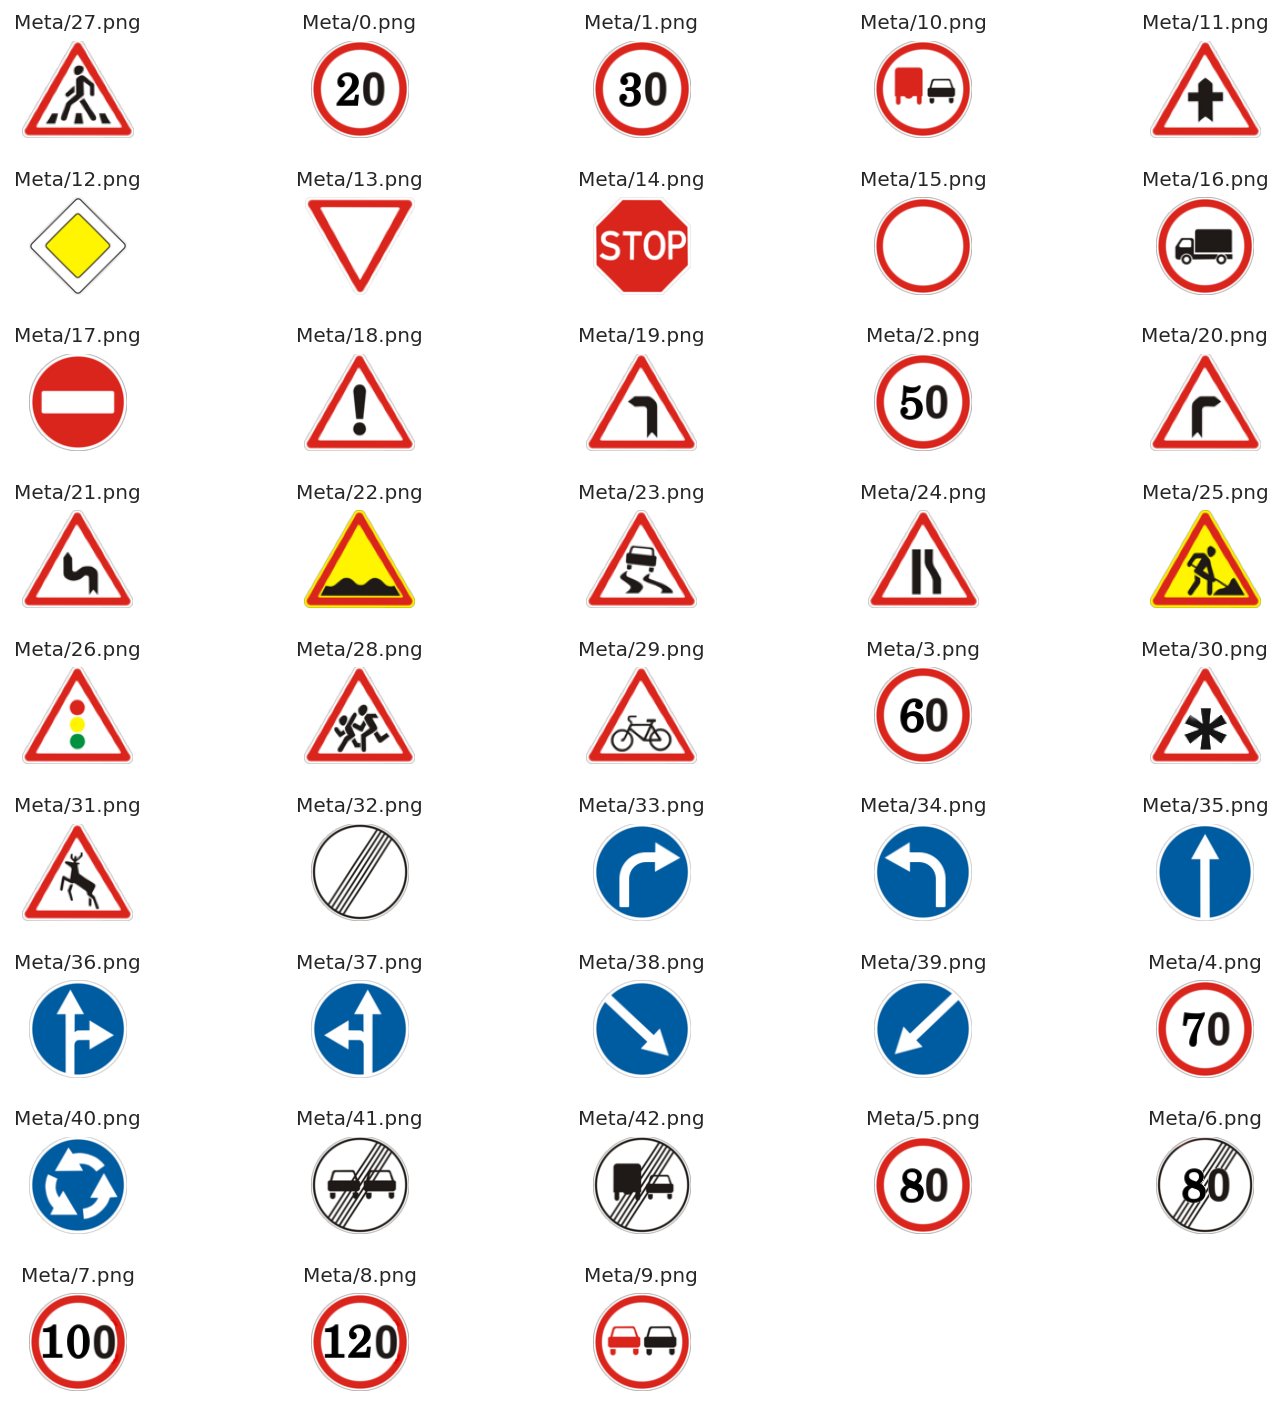

In [15]:
from PIL import Image

plt.figure(figsize=(10,10))
for i, file in enumerate(df.Path):
    img = Image.open(file)
    ax = plt.subplot(9,5,i+1)
    ax.imshow(img)
    ax.set_title(file, size=10)
    plt.axis('off')
plt.tight_layout()

Preprocess images to tensors

In [17]:
PATH = 'data/traffic signs/'
PATH=''
train_df = pd.read_csv(PATH+'Train.csv')
train_df.head(1)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png


In [18]:
train_x =[]

for i in train_df.Path:
    img = Image.open(PATH+i)       # reading image
    img = img.resize((50,50))     # reasizing image
    train_x.append(np.array(img)) # saving image as array to train

train_y = np.array(train_df.ClassId)
train_x = np.array(train_x)
print(train_x.shape)
print(train_y.shape)

(39209, 50, 50, 3)
(39209,)


Preprocess Test set

In [19]:
test_df = pd.read_csv(PATH+'Test.csv')
test_df.head(1)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png


In [20]:
test_x =[]
for i in test_df.Path:
    img = Image.open(PATH+i)
    img = img.resize((50,50))
    test_x.append(np.array(img))

test_y = np.array(test_df.ClassId)
test_x = np.array(test_x)
print(test_x.shape)
print(test_y.shape)

(12630, 50, 50, 3)
(12630,)


In [21]:
## Normalization
xtrain = train_x/255
xtest = test_x/255

In [22]:
import tensorflow.keras as keras

ytrain = keras.utils.to_categorical(train_y)
ytest = keras.utils.to_categorical(test_y)

In [23]:
Xtrain, Xtest, ytrain, ytest = train_test_split(xtrain, ytrain, test_size=0.2, random_state=RANDOM_SEED)
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(31367, 50, 50, 3)
(7842, 50, 50, 3)
(31367, 43)
(7842, 43)


PYTORCH

In [24]:
BATCH_SIZE=32
EPOCH = 150

X_train = torch.from_numpy(Xtrain).float()
y_train = torch.squeeze(torch.from_numpy(ytrain).float())
X_test = torch.from_numpy(Xtest).float()
y_test = torch.squeeze(torch.from_numpy(ytest).float())
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

train = torch.utils.data.TensorDataset(X_train,y_train)
validate = torch.utils.data.TensorDataset(X_test,y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = torch.utils.data.DataLoader(validate, batch_size = BATCH_SIZE, shuffle = False)

torch.Size([31367, 50, 50, 3]) torch.Size([31367, 43])
torch.Size([7842, 50, 50, 3]) torch.Size([7842, 43])


KERAS MODEL

In [25]:
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten

model = keras.models.Sequential()
model.add(Conv2D(filters=32, kernel_size= (5,5), strides=2, activation='relu', padding='same', input_shape=(50,50,3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), strides=2, activation='relu', padding='same'))
model.add(MaxPool2D((2,2), padding='valid'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5,5), strides=2, activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(5,5), strides=2, activation='relu', padding='same'))
model.add(MaxPool2D((2,2), padding='valid'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 6, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          102464    
                                                        

In [26]:
# Compiling the CNN model
model.compile(optimizer='sgd',
             loss='categorical_crossentropy',
             metrics = ['accuracy'])

In [27]:
## Fitting the model, with early stopping callback

earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights =True)

model_history = model.fit(Xtrain,ytrain, epochs=40,
                         validation_data=(Xtest,ytest),
                         callbacks=[earlystop_cb])

Epoch 1/40
981/981 [==============================] - 66s 67ms/step - loss: 3.5504 - accuracy: 0.0626 - val_loss: 3.4603 - val_accuracy: 0.0789
Epoch 2/40
981/981 [==============================] - 66s 68ms/step - loss: 3.3310 - accuracy: 0.1302 - val_loss: 3.0197 - val_accuracy: 0.1952
Epoch 3/40
981/981 [==============================] - 64s 65ms/step - loss: 2.4301 - accuracy: 0.3264 - val_loss: 2.3275 - val_accuracy: 0.3869
Epoch 4/40
981/981 [==============================] - 64s 66ms/step - loss: 1.4203 - accuracy: 0.5732 - val_loss: 1.2970 - val_accuracy: 0.6201
Epoch 5/40
981/981 [==============================] - 64s 65ms/step - loss: 1.0036 - accuracy: 0.6896 - val_loss: 1.3807 - val_accuracy: 0.5820
Epoch 6/40
981/981 [==============================] - 64s 65ms/step - loss: 0.7759 - accuracy: 0.7557 - val_loss: 0.5747 - val_accuracy: 0.8314
Epoch 7/40
981/981 [==============================] - 64s 65ms/step - loss: 0.6290 - accuracy: 0.8017 - val_loss: 0.3651 - val_accuracy:

In [28]:
model.save('model1.h5')

In [60]:
prob = model.predict(xtest)
pred = np.argmax(prob, axis=-1)


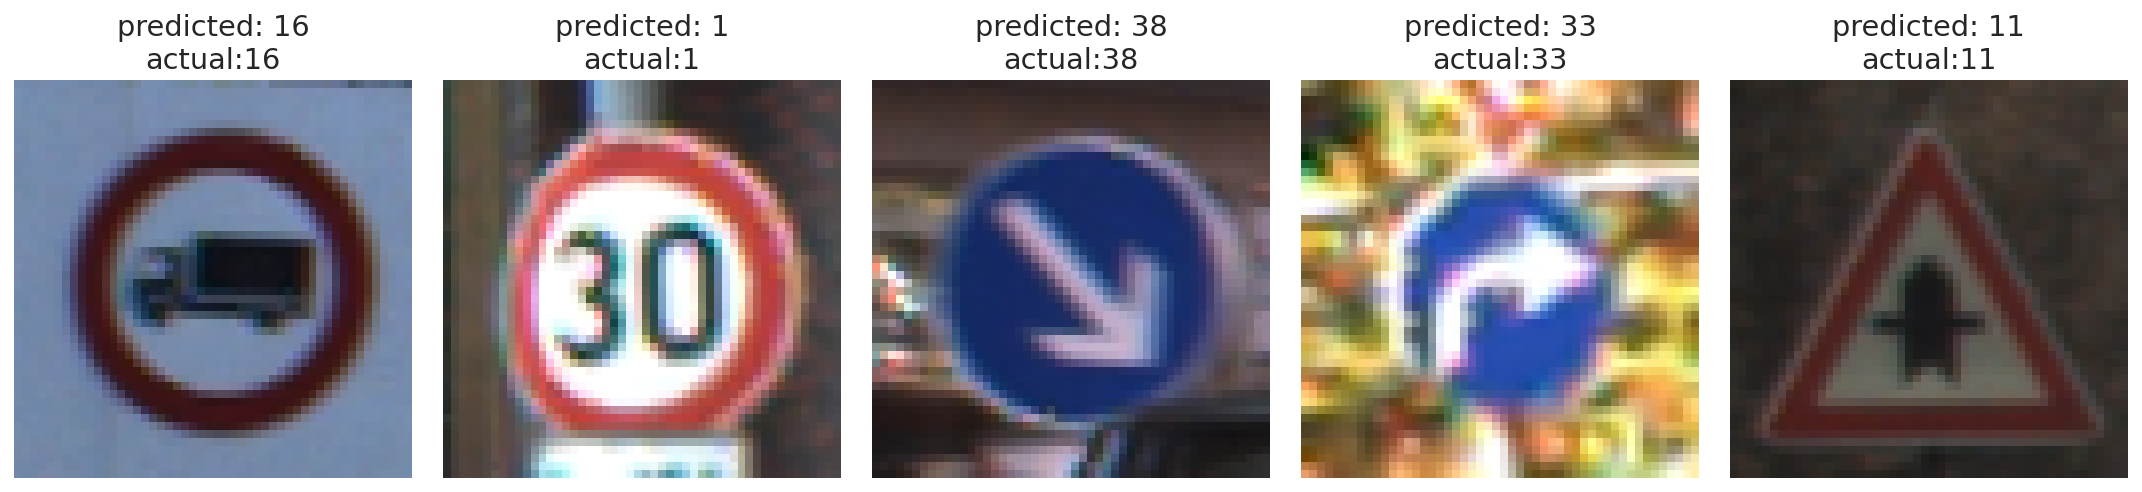

In [61]:
plt.figure(figsize=(30,30))
for i in range(5):
    ax = plt.subplot(5,10,i+1)
    ax.imshow(xtest[i])
    ax.set_title(f'predicted: {pred[i]}\nactual:{test_y[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [62]:
#print(len(test_y), len(pred)) # check if both have same amount of labels in the list
total = len(test_y)
correct = (pred == test_y).sum().item()
accuracy_testset = correct / total
print('Test accuracy: ', accuracy_testset)

Test accuracy:  0.9153602533650039
